In [11]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_ei_basic
from bo_functions import ExactGPModel
from bo_functions import calc_GP_outputs
from bo_functions import train_GP_model
from bo_functions import create_sse_point_data
from bo_functions import calc_y_exp

from bo_plotters import plot_hyperparams
from bo_plotters import y_plotter_basic
from bo_plotters import stdev_plotter_basic
from bo_plotters import ei_plotter_basic

In [12]:
#Pull x data from CSV
Theta_True = np.array([1,-1])
noise_std = 0

exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
# print(x)

In [13]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])

In [14]:
#Define GP Testing space
#Define Testing Space
p=10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta_space = torch.tensor(theta_mesh.T.reshape(-1, 2)) #25 x 2
# print(test_T)

The GP predicts that Theta1 = 1.1111111111111107 and Theta2 = -1.5555555555555556
The point that should be sampled next is Theta1 = -1.1111111111111112 and Theta2 = 2.0


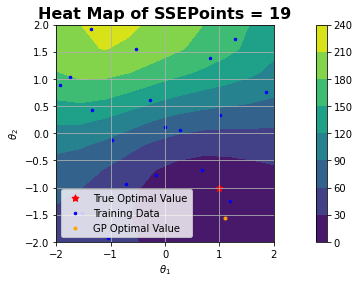

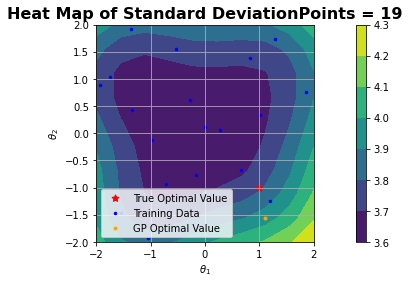

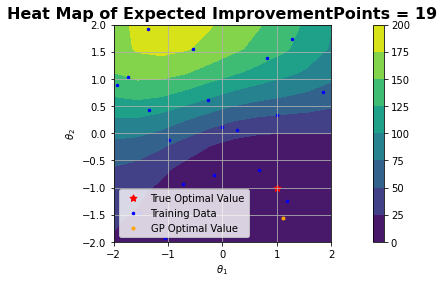

29
[-2.         -2.         -2.         -1.55555556 -2.         -1.11111111
 -2.         -0.66666667 -2.         -0.22222222 -2.          0.22222222
 -2.          0.66666667 -2.          1.11111111 -2.          1.55555556
 -2.          2.         -1.55555556 -2.         -1.55555556 -1.55555556
 -1.55555556 -1.11111111 -1.55555556 -0.66666667 -1.55555556 -1.55555556
  0.22222222 -1.55555556  0.66666667 -1.55555556  1.11111111 -1.55555556
  1.55555556 -1.55555556  2.         -1.11111111 -2.         -1.11111111
 -1.55555556 -1.11111111 -1.11111111 -1.11111111 -0.66666667 -1.11111111
 -0.22222222 -1.11111111  0.22222222 -1.11111111  0.66666667 -1.11111111
  1.11111111 -1.11111111  1.55555556 -1.11111111  2.         -0.66666667
 -2.         -0.66666667 -1.55555556 -0.66666667 -1.11111111 -0.66666667
 -0.66666667 -0.66666667 -0.22222222 -0.66666667  0.22222222 -0.66666667
  0.66666667 -0.66666667  1.11111111 -0.66666667  1.55555556 -0.66666667
  2.         -0.22222222 -2.         -0.22222222

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 2 but got size 1 for tensor number 1 in the list.

In [15]:
#Training the GP Model
iterations = 7000
BO_iter =3
for i in range(BO_iter):
    if torch.is_tensor(train_T) != True:
        train_T = torch.from_numpy(train_T)
    if torch.is_tensor(train_sse) != True:
        train_sse = torch.from_numpy(train_sse)
    # initialize likelihood and model
    ##Assumes a homoskedastic noise model p(y | f) = f + noise
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_T, train_sse, likelihood)
    train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
    noise_list = train_GP[0]
    lengthscale_list = train_GP[1]
    outputscale_list = train_GP[2]
    
    #Plot hyperparameters vs iteration
    noise_title = "Noise Hyperparameter"
    lengthscale_title = "Lengthscale Hyperparameter"
    outputscale_title = "Outputscale Hyperparameter"
#     plot_hyperparams(iterations, noise_list,noise_title)
#     plot_hyperparams(iterations, lengthscale_list,lengthscale_title)
#     plot_hyperparams(iterations, outputscale_list,outputscale_title)
    
    model.eval()
    #Puts likelihood in evaluation mode
    likelihood.eval()

    GP_Output = calc_GP_outputs(model, likelihood, theta_space)

    model_mean = GP_Output[0]
    model_variance = GP_Output[1]
    model_stdev = GP_Output[2]
    model_sse = GP_Output[3]

    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    Theta_Opt_GP = theta_space[np.argmin(model_sse)].numpy() #1x2
    print("The GP predicts that Theta1 =",Theta_Opt_GP[0],"and Theta2 =", Theta_Opt_GP[1])

    #calculates best_error and expected improvement
    best_error = np.argmax(model_sse)
    ei = calc_ei_basic(best_error,model_mean,model_variance)
    #Calculate Theta value that yields highest EI
    Theta_Best_Ei = theta_space[np.argmax(ei)].numpy()
    print("The point that should be sampled next is Theta1 =",Theta_Best_Ei[0],"and Theta2 =", Theta_Best_Ei[1])
    #Formats ei points into a suitable graphing form    
    ei_map = ei.reshape(len(Theta1),-1) # 5x5
    #Formats sse data points into a suitable graphing form    
    sse_map = model_sse.reshape(len(Theta1),-1) #5 x 5
    #Formats stdev data points into suitable graphing form
    stdev_map = model_stdev.reshape(len(Theta1),-1) #5 x 5
    # print(stdev_map)
    
    #Make Plots
    sse_title = "SSE"
    Theta_True = np.array([1,-1])
    y_plotter_basic(theta_mesh, sse_map, Theta_True, Theta_Opt_GP, train_T,sse_title,plot_train=True)
    
    stdev_plotter_basic(theta_mesh, stdev_map,Theta_True, Theta_Opt_GP,train_T,plot_train=True)
    ei_plotter_basic(theta_mesh, ei_map, Theta_True, Theta_Opt_GP,train_T,plot_train=True)
    
    print(Theta_Best_Ei)
    #Add Best values to training data   
    train_T = train_T.numpy()
    
    
    #NEED TO FIND sse VALUE ASSOCIATED WITH BEST THETA
    train_sse = train_sse.numpy()
    y_exp_new = calc_y_exp(Theta_True, Xexp, noise_std, noise_mean=0)
    append_sse = create_sse_point_data(Theta_Best_Ei, Xexp, Yexp)
#     append_sse = 0
#     for i in range(len(train_T)):
#         if np.array_equiv(train_T[i], Theta_Best_Ei) ==True:
#             print(i)
#             append_sse = train_sse[i]
            
    train_T = np.concatenate((train_T, [Theta_Best_Ei]), axis=0)
    train_sse = np.concatenate((train_sse,[append_sse]),axis=0)
    
#     print(train_T)
#         train_sse = torch.tensor(train_sse)